In [1]:
# give us interactive plots in jupyter lab:
# %matplotlib widget
%load_ext autoreload

import matplotlib
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy
from numpy.polynomial import Polynomial
import scipy.optimize as opt
from matplotlib.colors import TABLEAU_COLORS
from cycler import cycler
color_cycler = cycler(color=TABLEAU_COLORS)

In [2]:
import importlib
# import helper_libs as util
# importlib.reload(util)
# %autoreload 1
# %aimport helper_libs

In [3]:
def geomean(a):
    return np.exp( np.mean( np.log(a) ) )
print(f"Geomean of [2 8] {geomean([2,8])}")
class GEMMResults():
    def __init__( self, blob ):
        self.fine_axis = blob['fine_axis']
        self.blob = blob
        n = len(self.fine_axis)
        self.ncores = blob['OMP_NUM_THREADS']
        self.test_name = blob['test_name']
        self.blas = blob['blas']
        self.user_tag = blob.get('user_tag',"")
        self.generate_name()
        self.gflops = numpy.zeros( (n,n,n) )
        self.latency_usec = numpy.zeros( (n,n,n) )
        self.count = numpy.zeros( (n,n,n), dtype=numpy.int32 )
        a2i = { a:i for (i,a) in enumerate(self.fine_axis) }
        # print(blob['results'])
        for line in blob['results']:
            self.gflops[        a2i[line['m']], a2i[line['n']], a2i[line['k']] ] = line['gflops']
            self.latency_usec[  a2i[line['m']], a2i[line['n']], a2i[line['k']] ] = line['latency_usec']
            self.count[         a2i[line['m']], a2i[line['n']], a2i[line['k']] ] = line['count']
        # self.nelems = numpy.outer(numpy.outer( self.fine_axis, self.fine_axis ), self.fine_axis)
        self.nelems = np.multiply.outer( np.multiply.outer( self.fine_axis, self.fine_axis ), self.fine_axis )
        print(self.nelems.ravel().shape)

    def generate_name(self):
        if self.user_tag:
            self.name = f"{self.test_name}-{self.blas}-{self.ncores}-{self.user_tag}"
        else:
            self.name = f"{self.test_name}-{self.blas}-{self.ncores}"
        
    @classmethod
    def from_file(cls, fname):
        with open(fname) as fp:
            out = json.loads(fp.read())
        return cls(out)


fnames = []

# fnames.append('results-armpl_mp-24.10-c6gn.json')
# fnames.append('results-armpl_mp-24.10-c7gn.json')
# fnames.append('results-armpl_mp-24.10-hpc7g.json')
# fnames.append('results-nvpl_blas_lp64_gomp-r8g-1socket.json')

fnames.append('results-openblas-r8g-1socket.json')
fnames.append('results-nvpl_blas_lp64_gomp-r8g-1socket.json')
fnames.append('results-armpl_mp-24.10-r8g-1socket.json')

# fnames.append('results-openblas-r8g.json')
# fnames.append('results-nvpl_blas_lp64_gomp-r8g.json')
# fnames.append('results-armpl_mp-24.10-r8g.json')


# fnames.append('results-openblas-hpc7g.json')
# fnames.append('results-nvpl_blas_lp64_gomp-hpc7g.json')
# fnames.append('results-armpl_mp-24.10-hpc7g.json')

# fnames.append('results-mkl_intel_lp64-2024.2.0-hpc7a-1socket.json')
# fnames.append('results-openblas-hpc7a-1socket.json')

# fnames.append('results-mkl_intel_lp64-2024.2.0-hpc7a.json')
# fnames.append('results-openblas-hpc7a.json')

# fnames.append('results-mkl_intel_lp64-2024.2.0-hpc6id-1socket.json')
# fnames.append('results-mkl_intel_lp64-2024.2.0-hpc6id.json')
# fnames.append('results-armpl_mp-24.10-r8g.json')
# fnames.append('results-openblas.json')
# fnames.append('results-armpl_mp.json')
# fnames.append('results-armpl.json')
# fnames.append('results-openblas-grav4-24xl-b2.json')
# fnames.append('results-armpl_mp-grav4-24xl.json')
# fnames.append('results-armpl_mp-grav4-48xl.json')
# fnames.append('results-nvpl_blas_lp64_gomp-grav4-24xl.json')
# fnames.append('results-nvpl_blas_lp64_gomp-grav4-48xl.json')
# fnames.append('results-openblas-grav4-24xl.json')
# fnames.append('results-openblas-grav4-48xl.json')
# fnames.append('results-nvpl_blas_lp64_gomp-grav3.json')
# fnames.append('results-mkl_intel_lp64_192.json')
# fnames.append('results-mkl_intel_lp64-hpc7a_48xl.json')
# fnames.append('results-mkl_intel_lp64-hpc7a_24xl.json')
# fnames.append('results-mkl_intel_lp64_64.json')
# fnames.append('results-armpl_mp-pow2.json')
# fnames.append('results-armpl-pow2.json')

dats = [ GEMMResults.from_file('results/' + f) for f in fnames ]
for name, dat in zip(fnames, dats):
    if 'armpl' in name and not 'armpl_mp' in name:
        dat.ncores=1
        dat.generate_name()


Geomean of [2 8] 4.0
(4096,)
(4096,)
(4096,)


In [4]:
def movstats(x, y, xi, tol=10, logx=False):
    x = np.array(x)
    xi = np.array(xi)
    # if logx:
    #     x = np.log(x)
    #     tol = np.log(tol)
    stats = np.full( (6, len(xi)), np.nan )
    stats[0,:] = xi
    for jx, xii in  enumerate(xi):
        if logx:
            ii = (x < (xii * tol)) & (x > (xii / tol))
        else:
            ii = (x < (xii + tol)) & (x > (xii - tol))
        # print(f"{xii}: {ii.sum()}")
        if np.sum(ii) < 1: continue
        stats[1,jx] = np.mean(y[ii])
        p10, p50, p90 = np.percentile(y[ii],[10,50,90])
        stats[3,jx] = p10
        stats[4,jx] = p50
        stats[5,jx] = p90
        if np.sum(ii) < 2: continue
        stats[2,jx] = np.std(y[ii])
    return {'xi'   : stats[0,:],
            'mean' : stats[1,:],
            'std'  : stats[2,:],
            'p10'  : stats[3,:],
            'p50'  : stats[4,:],
            'p90'  : stats[5,:],
            'stats' : stats }
print( movstats(np.arange(0,100), np.arange(0,100), [10, 20, 50], 5)['stats'] )
# print( movstats(np.arange(0,100), np.arange(0,100), [10, 20, 50], 2, logx=True)['stats'] )

[[10.        20.        50.       ]
 [10.        20.        50.       ]
 [ 2.5819889  2.5819889  2.5819889]
 [ 6.8       16.8       46.8      ]
 [10.        20.        50.       ]
 [13.2       23.2       53.2      ]]


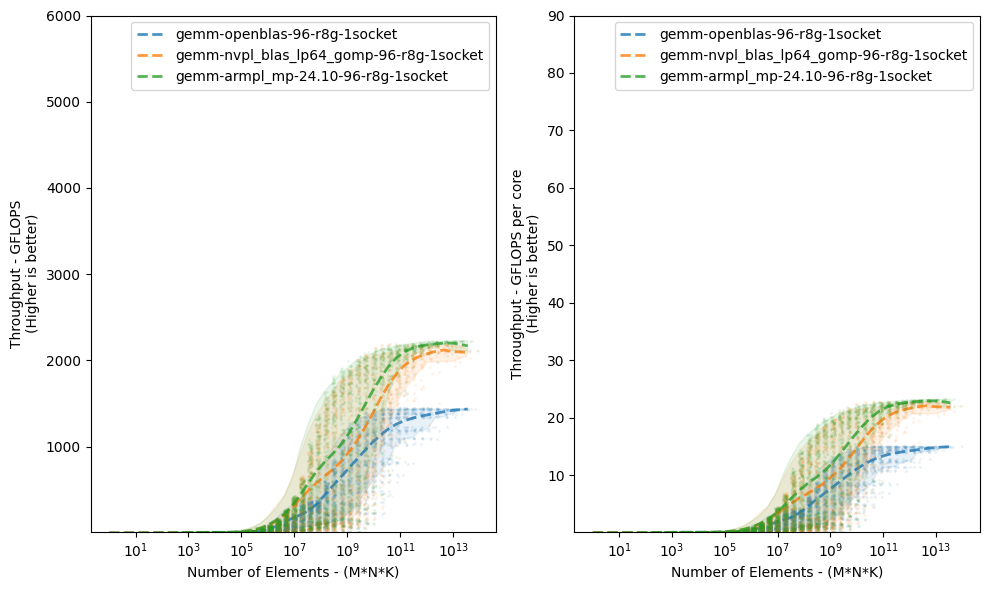

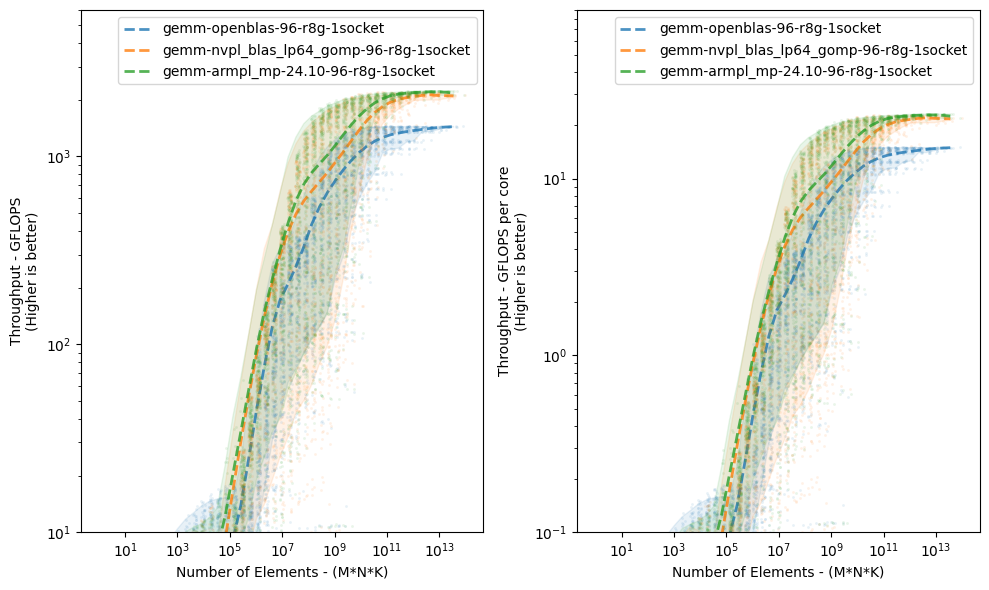

In [5]:
def plot_elems_vs_flops(dats, datref, logy=False):
    
    fig = plt.figure(figsize=(10,6))
    ii = datref.count > 0
    ax =     plt.subplot(1,2,1)
    # ax.plot( [ datref.latency_usec[ii].min(), datref.latency_usec[ii].max()], [1, 1], "--", color='grey', label="Reference")
    ax.set_xscale('log')
    curve_fit_with_logx = True
    curve_fit_tol = 2.5
    
    if logy:
        ax.set_yscale('log')
    for dat,style in zip(dats, color_cycler):
        ii = dat.count > 0
        xax = dat.nelems[ii] + .9*dat.nelems[ii]*(1+np.random.random( dat.nelems[ii].shape) )
        curve_ax = np.unique(dat.nelems[ii])
        stats = movstats(dat.nelems[ii], dat.gflops[ii], curve_ax, curve_fit_tol, logx=curve_fit_with_logx)
        plt.plot(stats['xi'], stats['mean'],'--', lw=2, label=dat.name, alpha=.8, **style)
        plt.fill( np.concatenate( (curve_ax, curve_ax[::-1])), np.concatenate( (stats['p10'], stats['p90'][::-1])), alpha=.1, **style, label=None)
        plt.plot(xax, dat.gflops[ii],'.', label=None, alpha=.1, linestyle='none', markersize=4, mec='none', **style)
        # plt.plot(10*np.log10(dat.latency_usec[ii]), 10*np.log10(dat.gflops[ii]/datref.gflops[ii]),'.', label=dat.name, alpha=.8, linestyle='none', markersize=4, mec='none')
    plt.xlabel("Number of Elements - (M*N*K)")
    plt.ylabel("Throughput - GFLOPS\n(Higher is better)")
    ax.set_ylim([10, 6000])
    plt.legend(markerscale=3)
    ax =     plt.subplot(1,2,2)
    if logy:
        ax.set_yscale('log')
    ax.set_xscale('log')
    for dat,style in zip(dats, color_cycler):
        ii = dat.count > 0
        xax = dat.nelems[ii] + .9*dat.nelems[ii]*(1+np.random.random( dat.nelems[ii].shape) )
        curve_ax = np.unique(dat.nelems[ii])
        stats = movstats(dat.nelems[ii], dat.gflops[ii]/dat.ncores, curve_ax, curve_fit_tol, logx=curve_fit_with_logx)
        plt.plot(stats['xi'], stats['mean'],'--', lw=2, label=dat.name, alpha=.8, **style)
        plt.fill( np.concatenate( (curve_ax, curve_ax[::-1])), np.concatenate( (stats['p10'], stats['p90'][::-1])), alpha=.1, **style, label=None)
        
        plt.plot(xax, dat.gflops[ii]/dat.ncores,'.', label=None, alpha=.1, linestyle='none', markersize=4, mec='none', **style)
        # plt.plot(10*np.log10(dat.latency_usec[ii]), 10*np.log10(dat.gflops[ii]/datref.gflops[ii]),'.', label=dat.name, alpha=.8, linestyle='none', markersize=4, mec='none')
    plt.xlabel("Number of Elements - (M*N*K)")
    plt.ylabel("Throughput - GFLOPS per core\n(Higher is better)")
    ax.set_ylim([.1, 90])
    plt.legend(markerscale=3)
    fig.tight_layout()

plot_elems_vs_flops(dats, dats[0])
plot_elems_vs_flops(dats, dats[0], True)

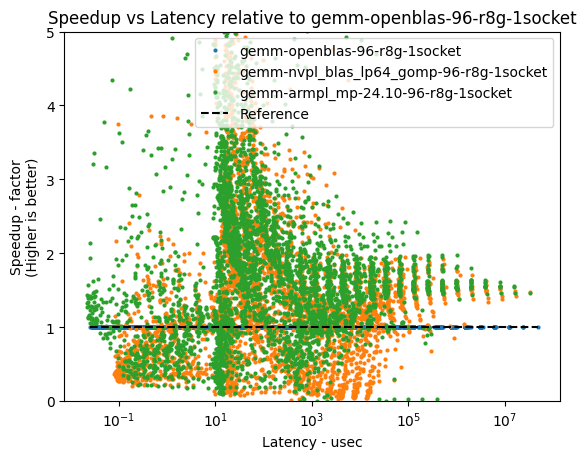

In [6]:
def plot_improvement_vs_latency(dats,datref):
    fig = plt.figure()
    ax = plt.subplot(1,1,1)
    for dat in dats:
        # if dat == datref: continue
        ii = dat.count > 0
        # plt.plot(10*np.log10(dat.nelems[ii]), 10*np.log10(dat.gflops[ii]/datref.gflops[ii]),'.', label=dat.name, alpha=.8, linestyle='none', markersize=4, mec='none')
        ax.plot(dat.latency_usec[ii], dat.gflops[ii]/datref.gflops[ii],'.', label=dat.name, alpha=1, linestyle='none', markersize=6, mec='none')
    ii = datref.count > 0
    ax.plot( [ datref.latency_usec[ii].min(), datref.latency_usec[ii].max()], [1, 1], "--", color='black', label="Reference")
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_ylim([0, 5])
    plt.xlabel("Latency - usec")
    plt.ylabel("Speedup - factor\n(Higher is better)")
    ax.set_title(f"Speedup vs Latency relative to {datref.name}")
    ax.legend()
plot_improvement_vs_latency(dats, dats[0])

In [7]:
def print_summary(dats, dat_filt_fun, filter_name):
    # fig = plt.figure()
    # ax1 = plt.subplot(2,1,1)
    # ax2 = plt.subplot(2,1,2)
    geomeans = []
    latencymeans = []

    print(f"--------- For {filter_name}")
    for jdat,dat in enumerate(dats):
        ii = (dat.count > 0)
        ii = ii & dat_filt_fun(dat)
        # ii = ii & (dat.latency_usec > 100000)
        
        mean_lat = np.mean( dat.latency_usec[ii] )
        geomean_gflops = geomean( dat.gflops[ii] )
        print(f"Geomean of GFLOPS: {geomean_gflops:8.2f} ({geomean_gflops/dat.ncores:8.3f}/core). Mean Latency {1e-3*mean_lat:7.5f} msec for {dat.name:25s} ({ii.sum():4d} matched)")
    
        # plt.plot(10*np.log10(dat.nelems[ii]), 10*np.log10(dat.gflops[ii]/datref.gflops[ii]),'.', label=dat.name, alpha=.8, linestyle='none', markersize=4, mec='none')
        # ax.plot(dat.latency_usec[ii], dat.gflops[ii]/datref.gflops[ii],'.', label=dat.name, alpha=.8, linestyle='none', markersize=4, mec='none')
    # xaxis = np.linspace(0, len(dats), len(dats))
    # width = 1

    # print(geomeans)
    # print(xaxis)
    # ax1.bar(xaxis, geomeans, width=width)
    # plt.xlabel("Latency - usec")
    # plt.ylabel("Speedup - factor\n(Higher is better)")
print_summary(dats, lambda dat: dat.nelems < 100000, "GEMM with nelem < 100000")
print_summary(dats, lambda dat: dat.latency_usec < 1000, "GEMM with latency < 1 msec")
print_summary(dats, lambda dat: dat.latency_usec > 20000, "GEMM with latency > 20 msec")

--------- For GEMM with nelem < 100000
Geomean of GFLOPS:     5.16 (   0.054/core). Mean Latency 0.00670 msec for gemm-openblas-96-r8g-1socket ( 966 matched)
Geomean of GFLOPS:     3.25 (   0.034/core). Mean Latency 0.01019 msec for gemm-nvpl_blas_lp64_gomp-96-r8g-1socket ( 966 matched)
Geomean of GFLOPS:     4.68 (   0.049/core). Mean Latency 0.01169 msec for gemm-armpl_mp-24.10-96-r8g-1socket ( 966 matched)
--------- For GEMM with latency < 1 msec
Geomean of GFLOPS:    31.41 (   0.327/core). Mean Latency 0.13851 msec for gemm-openblas-96-r8g-1socket (2941 matched)
Geomean of GFLOPS:    38.38 (   0.400/core). Mean Latency 0.11319 msec for gemm-nvpl_blas_lp64_gomp-96-r8g-1socket (2903 matched)
Geomean of GFLOPS:    52.80 (   0.550/core). Mean Latency 0.11486 msec for gemm-armpl_mp-24.10-96-r8g-1socket (3037 matched)
--------- For GEMM with latency > 20 msec
Geomean of GFLOPS:   839.67 (   8.747/core). Mean Latency 950.80592 msec for gemm-openblas-96-r8g-1socket ( 425 matched)
Geomean o

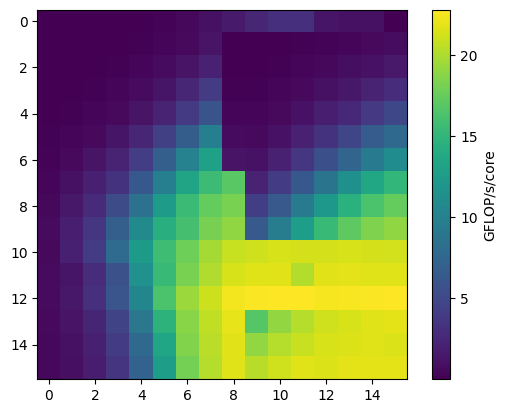

In [8]:
fig = plt.figure()
dat = dats[1]
ax = plt.subplot(1,1,1)
flops1 = dat.gflops[12,:,:]
im = ax.imshow(flops1/dat.ncores)

t = fig.colorbar(im, label='GFLOP/s/core')

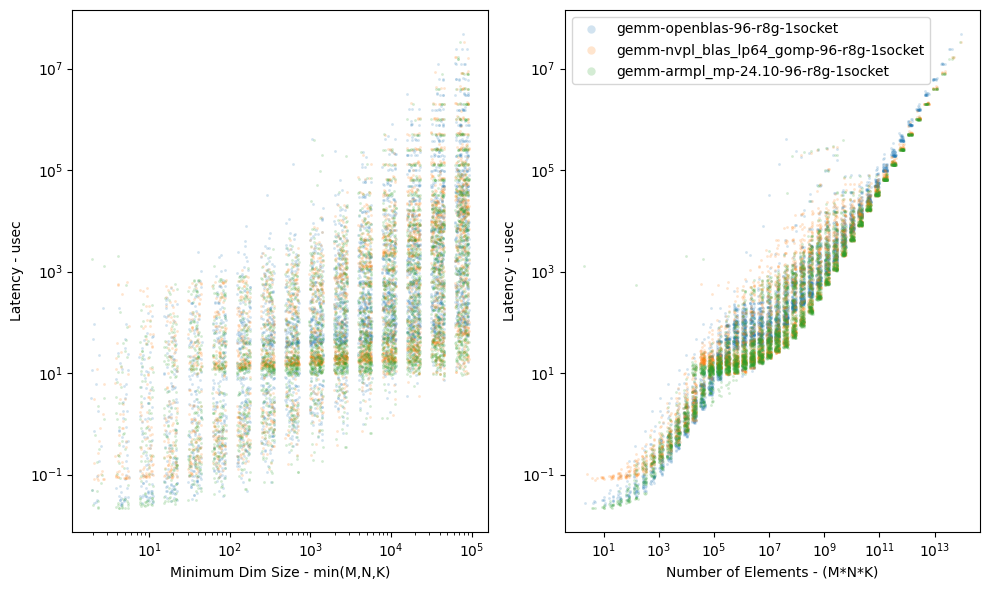

In [9]:
def plot_mindim_vs_flops(dats, datref, logy=False):
    
    fig = plt.figure(figsize=(10,6))
    ii = datref.count > 0
    
    # ax.plot( [ datref.latency_usec[ii].min(), datref.latency_usec[ii].max()], [1, 1], "--", color='grey', label="Reference")
    for j in range(2):
        ax = plt.subplot(1,2,j+1)
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.ylabel("Latency - usec")
    curve_fit_with_logx = True
    curve_fit_tol = 2.5

    def jitterax(dim_base):
        return dim_base + .9*dim_base*(1+np.random.random( dim_base.shape) )

    
    for dat,style in zip(dats, color_cycler):
        ii = dat.count > 0
        (m,n,k) = np.meshgrid(dat.fine_axis,dat.fine_axis,dat.fine_axis)
        mindim = np.minimum(m,n,k)
        maxdim = np.maximum(m,n,k)
        ax = plt.subplot(1,2,1)
        plt.plot(jitterax(mindim[ii]), dat.latency_usec[ii],'.', label=dat.name, alpha=.2, linestyle='none', markersize=4, mec='none', **style)
        # ax = plt.subplot(1,2,2)
        # plt.plot(jitterax(maxdim[ii]), dat.latency_usec[ii],'.', label=dat.name, alpha=.2, linestyle='none', markersize=4, mec='none', **style)
        ax = plt.subplot(1,2,2)
        plt.plot(jitterax(dat.nelems[ii]), dat.latency_usec[ii],'.', label=dat.name, alpha=.2, linestyle='none', markersize=4, mec='none', **style)

    plt.subplot(1,2,1)
    plt.xlabel("Minimum Dim Size - min(M,N,K)")
    # plt.subplot(1,3,2)
    # plt.xlabel("Maximum Dim Size - max(M,N,K)")
    plt.subplot(1,2,2)
    plt.xlabel("Number of Elements - (M*N*K)")
    
    # ax.set_ylim([10, 6000])
    plt.legend(markerscale=3)
    fig.tight_layout()

plot_mindim_vs_flops(dats, dats[0])
# plot_elems_vs_flops(dats, dats[0], True)